### Résumé de tâche :

**L’objectif** est : pour un prompt et deux réponses données R et R* où R* est une **« bonne réponse »**, est-ce que « R est aussi bonne que R* » ?
> ⬆️ Comparaison

Plus **précisément** : 
1. Ont-elles des points communs ?  `analyse`
2. Des différences ? `analyse`
3. Elles se complètent ? En les combinant, on obtiendrait une réponse encore meilleure ?  `génération+évaluation`



> - Analyser le problème, proposer une solution et l’implémenter.
> - Pas besoin de chercher à faire le meilleur modèle possible (ni de tester des dizaines de modèles)
> - Se Concentrer sur l’analyse du problème, la proposition d’une solution pertinente et la qualité du code Python d’implémentation de la solution.


Analyser le problème :
- Tout d'abord, comment déterminer les critères de R, notamment **R***, autrement dit, comment devrait-on subdiviser les notes de contenu.
- Dans quel aspects on peut trouver des sim. et diff.  entre R et R* ?
- Comment fusionner R et R* pour générer une nouvelle réponse.
- Comment évaluer le(s) nouvelle(s) réponse(s).

---

### 1️⃣ Importation des données

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import re
from nltk.tokenize import word_tokenize
from nltk import ngrams
from sentence_transformers import SentenceTransformer, util
import torch
import os
from openai import OpenAI
from getpass import getpass
import json
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


In [2]:
# importer les données
prompts_train_df = pd.read_csv('data/prompts_train.csv')
reponses_train_df = pd.read_csv('data/summaries_train.csv')

In [3]:
# vérifier la taille des données
reponses_train_df.shape

(7165, 5)

In [4]:
# vérifier les premières lignes des données pour avoir une idée de la structure
reponses_train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


---

### 2️⃣ EDA (Exploratory Data Analysis) et Ingénierie des caractéristiques

In [5]:
# obtenir le nombre de réponses uniques et de prompts uniques
unique_reponses = reponses_train_df['student_id'].nunique()
unique_prompts = reponses_train_df['prompt_id'].nunique()

# obtenir les données statistiques descriptives sur les scores de "content".
score_stats = reponses_train_df['content'].describe()
print('réponses uniques:', unique_reponses)
print('prompts uniques:', unique_prompts)
print('*'*90)
print('Statistiques de score de content :')
print(score_stats)
print('*'*90)

réponses uniques: 7165
prompts uniques: 4
******************************************************************************************
Statistiques de score de content :
count    7165.000000
mean       -0.014853
std         1.043569
min        -1.729859
25%        -0.799545
50%        -0.093814
75%         0.499660
max         3.900326
Name: content, dtype: float64
******************************************************************************************


🔍 Un grand nombre d'élèves ont des scores négatifs.
🔍 Une diversité de réponses en termes de qualité de contenu.

---

On va ensuite effectuer les opérations suivantes sur les deux DataFrames `prompt_train_df` et `reponses_train_df`:
1. Fusionner les 2 dfs et faire certains prétraitement
2. Supprimer la colonne "wording"
3. Ajouter d'autres caractéristiques

In [6]:
# fusionner
merged_df = reponses_train_df.merge(prompts_train_df[['prompt_id', 'prompt_text','prompt_question']], on='prompt_id', how='left')


# rendre it lower 
merged_df = merged_df.apply(lambda s: s.lower() if type(s) == str else s)

# s'assurer que tout ce qui doit être str soit str
merged_df["text"]=[str(data) for data in merged_df.text] 
merged_df["prompt_text"]=[str(data) for data in merged_df.prompt_text] 

# éliminer les ponctuations
# merged_df["text"]=merged_df.text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
# merged_df["prompt_text"]=merged_df.prompt_text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
# Les ponctuations sont parfois utiles pour identifier les citations dans une réponse.


# supprimer wording score
merged_df = merged_df.drop(columns=['wording'])

In [14]:
merged_df.head()

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,71,673,0.105498,51,21,2,0,0,0.076190,0.659943
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,58,1175,0.049362,38,31,18,8,0,0.085427,0.495908
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",289,659,0.438543,149,65,30,9,2,0.211640,0.784489
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",41,659,0.062215,19,13,5,4,0,0.047468,0.575283
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,263,673,0.390788,138,46,20,4,4,0.142857,0.752955


In [8]:
# Découvrir d'autres caractéristiques

In [9]:
# Ajout de nouvelles fonctions pour explorer caractéristiques

def feature_engineering(df):
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # calculer la longueur de chaque réponse
    def compte_texte_longueur(df, col, tokenizer):
        longueur_col = df[col].apply(lambda x: len(tokenizer.encode(x)))
        return longueur_col
    
    # fonction pour calculer la similarité sémantique entre une réponse et son prompt texte
    def sim_semantique(ligne, model, prompt_embeddings):
        prompt_vecteur = prompt_embeddings[ligne['prompt_id']]
        reponse_vecteur = model.encode(ligne['text'], batch_size=1, show_progress_bar=False)
        return util.cos_sim([prompt_vecteur], [reponse_vecteur]).item()
    

    def citation_count(ligne):
        reponse = ligne['text']
        text    = ligne['prompt_text']
        cite_dans_rep = re.findall(r'"([^"]*)"', reponse)
        return [citation in text for citation in cite_dans_rep].count(True)
    
    
    def word_ngram_chevauchement(ligne, n):
        prompt_tokens = ligne['prompt_text'].split()
        reponse_tokens = ligne['text'].split()

        prompt_ngrams = set(ngrams(prompt_tokens, n))
        reponse_ngrams = set(ngrams(reponse_tokens, n))
        
        common_ngrams = prompt_ngrams.intersection(reponse_ngrams)
        
        return len(common_ngrams) / len(reponse_ngrams) if len(reponse_ngrams) else 0, len(common_ngrams)

    
    # ensuite, on les exécuter
    
    df['reponse_longueur'] = compte_texte_longueur(df, 'text',tokenizer)
    df['prompt_longueur'] = compte_texte_longueur(df, 'prompt_text',tokenizer)
    df['rep/prompt_ratio'] = df['reponse_longueur'] / df['prompt_longueur']
    
    df['vocabulaire_taille'] = df['text'].apply(lambda x: len(set(x.split())))
    df['unigram_overlap'] = df.apply(lambda row: len(set(row['prompt_text'].split()) & set(row['text'].split())), axis=1)
    df['bigram_overlap']  = df.apply(lambda x: word_ngram_chevauchement(x,2)[1], axis=1 )
    df['trigram_overlap'] = df.apply(lambda x: word_ngram_chevauchement(x,3)[1], axis=1 )
    
    df['citation'] = df.apply(citation_count, axis=1)    
    df['jaccard_similarité'] = df.apply(lambda row: len(set(word_tokenize(row['prompt_text'])) & set(word_tokenize(row['text']))) / len(set(word_tokenize(row['prompt_text'])) | set(word_tokenize(row['text']))), axis=1)
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embeddings_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1', device=device)
    prompt_to_emb_dict = df.groupby('prompt_id')['prompt_text'].first().transform(lambda x: embeddings_model.encode(x, batch_size=1, show_progress_bar=False)).to_dict()
    df['similarité_sémantique'] = df.apply(lambda row: sim_semantique(row, embeddings_model, prompt_to_emb_dict), axis=1)

    return df


In [10]:
merged_df_featured = feature_engineering(merged_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/sent

In [11]:
merged_df_featured.head()

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,71,673,0.105498,51,21,2,0,0,0.076190,0.659943
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,58,1175,0.049362,38,31,18,8,0,0.085427,0.495908
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",289,659,0.438543,149,65,30,9,2,0.211640,0.784489
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",41,659,0.062215,19,13,5,4,0,0.047468,0.575283
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,263,673,0.390788,138,46,20,4,4,0.142857,0.752955


In [12]:
# garder en csv
merged_df_featured.to_csv('data/merged_df_featured.csv', index=False)


---

## 3️⃣ Étudier les corrélations des features

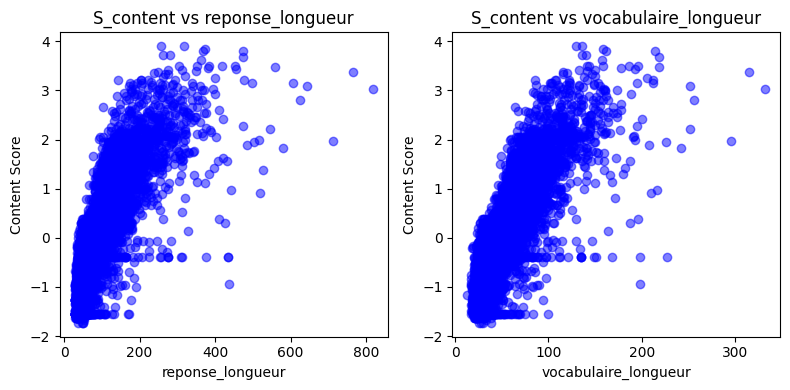

(0.7830246843816084, 0.806766673766287)

In [13]:
# Une première visualisation


# Configuration de la figure et des axes pour deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), dpi=100)

# Graphique pour le score et la longueur de réponse
ax1.scatter(merged_df_featured['reponse_longueur'], merged_df_featured['content'], alpha=0.5, color='blue')
ax1.set_title('S_content vs reponse_longueur')
ax1.set_xlabel('reponse_longueur')
ax1.set_ylabel('Content Score')

# Graphique pour le score et le nombre de mots uniques
ax2.scatter(merged_df_featured['vocabulaire_taille'], merged_df_featured['content'], alpha=0.5, color='blue')
ax2.set_title('S_content vs vocabulaire_longueur')
ax2.set_xlabel('vocabulaire_longueur')
ax2.set_ylabel('Content Score')


plt.tight_layout()
plt.show()

# Calcul de la corrélation
word_count_content_corr = merged_df_featured['reponse_longueur'].corr(merged_df_featured['content'])
vocabulary_richness_corr = merged_df_featured['vocabulaire_taille'].corr(merged_df_featured['content'])


(word_count_content_corr, vocabulary_richness_corr)

1. Une corrélation positive évidente
2. La quantité de mots uniques utilisés a un impact plus important sur le score de contenu que la simple longueur du texte

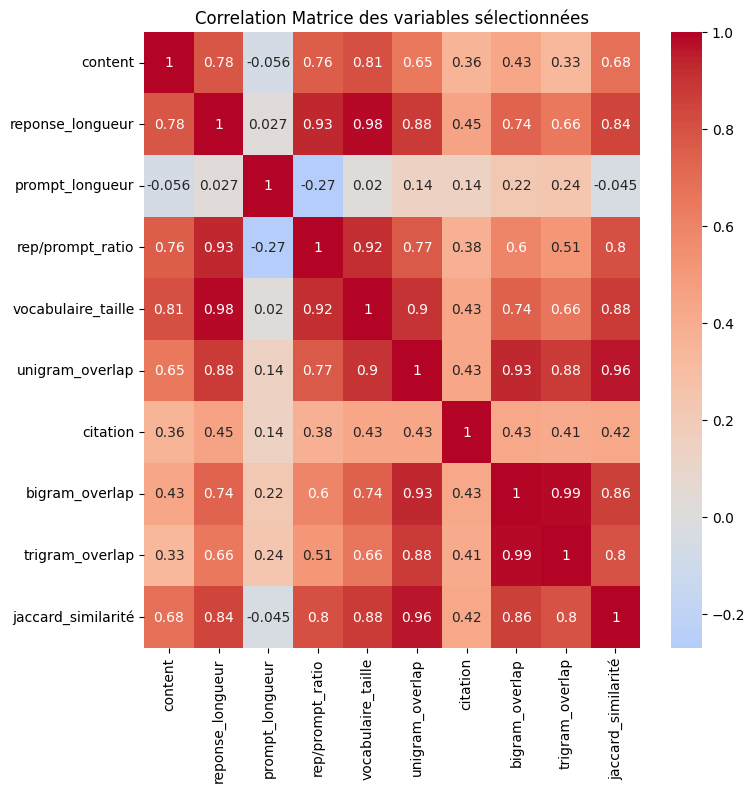

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
selected_vars = ['content', 'reponse_longueur', 'prompt_longueur', 'rep/prompt_ratio', 'vocabulaire_taille', 'unigram_overlap', 'citation', 'bigram_overlap', 'trigram_overlap', 'jaccard_similarité']

subset_df = merged_df_featured[selected_vars]

# Calculer le correlation matrice
correlation_matrice = subset_df.corr()

plt.figure(figsize=(8, 8))

sns.heatmap(correlation_matrice, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrice des variables sélectionnées")
plt.show()

---

## 4️⃣ Définir le R et R*

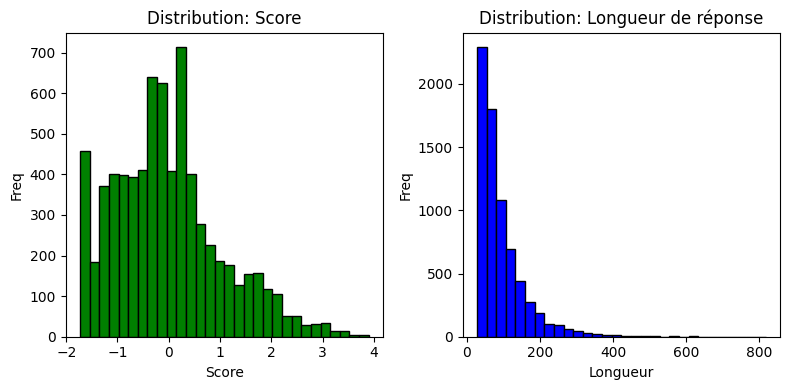

In [16]:
# un peu de visualisation pour la distribution des data
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plotting histograms
ax[0].hist(reponses_train_df['content'], bins=30, color='green', edgecolor='black')
ax[0].set_title('Distribution: Score')
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Freq')

ax[1].hist(merged_df_featured['reponse_longueur'], bins=30, color='blue', edgecolor='black')
ax[1].set_title('Distribution: Longueur de réponse')
ax[1].set_xlabel('Longueur')
ax[1].set_ylabel('Freq')

# Adjusting the layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()

**Distribution du score:** légèrement asymétrique à gauche, mais globalement une distribution normale avec un pic légèrement inférieur à zéro.

**Distribution du nombre de mots dans les résumés:** Fortement asymétrique. La plupart des résumés contiennent un nombre relativement faible de mots.

---
**Pour évaluer la qualité d'une réponse, nous pouvons diviser l'ensemble de données comme suit :**

- Réponses de qualité inférieure :             n <= -1
- Réponses moyennes          :              -1 < n < 1
- Bonnes réponses         :                1 <= n <= 3
- Réponses excellentes      :                    n > 3


In [72]:
def categoriser_score(n):
    if n <= 0:
        return 'mauvais'
    elif n <= 1:
        return 'moyen'
    elif n <= 3:
        return 'bon'
    else: # n > 3
        return 'excellent'

# Appliquer cette fonction et créer une nouvelle colonne 'quality_category'
merged_df_featured['cat'] = merged_df_featured['content'].apply(categoriser_score)
merged_df_featured.to_csv('data/merged_df_featured_cat.csv', index=False)


In [73]:
merged_df_featured.head()

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique,cat
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,71,673,0.105498,51,21,2,0,0,0.076190,0.659943,moyen
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,58,1175,0.049362,38,31,18,8,0,0.085427,0.495908,mauvais
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",289,659,0.438543,149,65,30,9,2,0.211640,0.784489,excellent
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",41,659,0.062215,19,13,5,4,0,0.047468,0.575283,mauvais
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,263,673,0.390788,138,46,20,4,4,0.142857,0.752955,excellent


In [74]:
# Comptes de chaque cat
cat_stats = merged_df_featured['cat'].value_counts()
cat_stats

cat
mauvais      4064
moyen        1947
bon          1085
excellent      67
Name: count, dtype: int64

In [129]:
# Ensuite, extraire!

# On va extraire une réponse provenant des catégories "bon" ou "excellent"
# Puis on extrait une réponse d'un élève choisi au hasard, mais sur le même prompt.


# Sélection aléatoire un enregistrement parmi les 'bon' ou les 'excellent'
good_answers_df = merged_df_featured[merged_df_featured['cat'].isin(['bon', 'excellent'])]
r_star = good_answers_df.sample(n=1)

# En fonction du prompt_id de la réponse sélectionnée, trouver une autre réponse
r_random = merged_df_featured[merged_df_featured['prompt_id'] == r_star['prompt_id'].values[0]].drop(r_star.index).sample(n=1)


# # Suppression de ces deux enregistrements du DataFrame original
# merged_df_featured = merged_df_featured.drop(r_star.index)
# merged_df_featured = merged_df_featured.drop(r_random.index)

---

## 5️⃣ Comparer les deux réponses

In [130]:
# Affichage des résultats
r_star

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique,cat
6003,d5c0955a38bf,ebad26,One way they would cover up spoiled mean is by...,1.910893,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,134,1175,0.114043,69,34,18,6,0,0.085847,0.621054,bon


In [131]:
r_random

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique,cat
957,22519d09a5d4,ebad26,They would pickle the spoiled meet to make it ...,0.388379,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,86,1175,0.073191,49,37,42,38,1,0.10396,0.636407,moyen


Top N Keywords for Document 1:
paragraph: 0.3418385244544408
they: 0.21378036279500556
meat: 0.1997211725243894
anattractive: 0.19348733703586177
combing: 0.19348733703586177

Top N Keywords for Document 2:
actualy: 0.2847929421780695
uo: 0.272219536486327
would: 0.24927122693674159
sour: 0.23678983350072907
to: 0.229527883553944


In [132]:
# 可以通过向量 相似度，特征选择自己生成的
# 也可以通过词汇展示：通过 word embedding 或者 tfidf 提取关键词进行陈述

In [133]:

def extract_features_features(df):
    feature_columns = ['reponse_longueur', 'rep/prompt_ratio', 'vocabulaire_taille', 'unigram_overlap', 'bigram_overlap','trigram_overlap','citation','jaccard_similarité','similarité_sémantique']
    feature_data = df[feature_columns]
    return feature_data
    
def normalization(feature_data):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_data)
    return scaled_features

features = extract_features_features(merged_df_featured)
features_normalise = normalization(features)


In [134]:
import numpy as np

cosine_sim = cosine_similarity(features_normalise)
cosine_sim_df = pd.DataFrame(cosine_sim, index=merged_df_featured['student_id'], columns=merged_df_featured['student_id'])
cosine_sim_df.head()

student_id,000e8c3c7ddb,0020ae56ffbf,004e978e639e,005ab0199905,0070c9e7af47,0071d51dab6d,0072b649a88c,00746c7c79c3,00791789cc1f,0086ef22de8f,...,ff53b94f7ce0,ff5b8d659ca6,ff5e9e6068da,ff66def9f97c,ff78813d4f7b,ff7c7e70df07,ffc34d056498,ffd1576d2e1b,ffe4a98093b2,fffbccfd8a08
student_id,,,,,,,,,,,,,,,,,,,,,
000e8c3c7ddb,1.000000,0.258334,-0.335766,0.708078,-0.267692,0.661750,0.766250,0.447418,0.410067,0.729409,...,-0.949869,-0.423165,0.786989,0.550892,-0.146979,-0.377341,0.341716,0.897729,0.622325,-0.447462
0020ae56ffbf,0.258334,1.000000,-0.897180,0.724489,-0.798577,0.818707,0.364278,0.907890,0.911107,0.757807,...,-0.254078,-0.932141,0.600173,-0.252238,-0.495978,0.082284,0.825240,0.548305,0.789775,-0.372908
004e978e639e,-0.335766,-0.897180,1.000000,-0.832436,0.894786,-0.810581,-0.232123,-0.877618,-0.814205,-0.828861,...,0.394025,0.925593,-0.792920,0.325090,0.487872,-0.153939,-0.713526,-0.584992,-0.688271,0.564857
005ab0199905,0.708078,0.724489,-0.832436,1.000000,-0.632888,0.946626,0.590486,0.875128,0.800808,0.979814,...,-0.737865,-0.875094,0.941399,0.096355,-0.228855,0.018678,0.760730,0.904316,0.828322,-0.512327
0070c9e7af47,-0.267692,-0.798577,0.894786,-0.632888,1.000000,-0.601311,-0.207654,-0.692194,-0.711733,-0.642357,...,0.381358,0.762608,-0.678571,0.185929,0.784881,0.189972,-0.548960,-0.439618,-0.556677,0.782235


In [138]:
# reponse_id
R_id = r_random['student_id'].iloc[0]
R_star_id = r_star['student_id'].iloc[0]


# obtenir la similarite cosinus entre R et R*
cos_sim_value = cosine_sim_df.loc[R_id, R_star_id]

# Vérifier leur score et leur similarité cosinus
content_1 = merged_df_featured.loc[merged_df_featured['student_id'] == student_id_1, 'content'].values[0]
content_2 = merged_df_featured.loc[merged_df_featured['student_id'] == student_id_2, 'content'].values[0]
print(content_1,content_2)
print(cos_sim_value)

-1.54716321678788 0.205682506482641
-0.39770800800870365


In [146]:
sample_size = 500


# Init d'un Dataframe
results_df = pd.DataFrame(columns=['student_id_1', 'student_id_2', 'content_diff', 'cosine_similarity'])

sampled_pairs = merged_df_featured.sample(n=sample_size, replace=False)

for _, row in sampled_pairs.iterrows():
    student_id_1 = row['student_id']
    student_id_2 = merged_df_featured[merged_df_featured['student_id'] != student_id_1].sample(n=1)['student_id'].values[0]
    
    content_1 = row['content']
    content_2 = merged_df_featured[merged_df_featured['student_id'] == student_id_2]['content'].values[0]
    content_diff = abs(content_1 - content_2)
    
    cos_sim_value = cosine_sim_df.loc[student_id_1, student_id_2]
    
    results_df = pd.concat([results_df, pd.DataFrame([{
        'student_id_1': student_id_1,
        'student_id_2': student_id_2,
        'content_diff': content_diff,
        'cosine_similarity': cos_sim_value
    }])], ignore_index=True)

# Maintenant, results_df contient les différences de contenu et les similarités cosinus des paires d'échantillons sélectionnées au hasard.




/var/folders/sl/dmcfd6sn2xz848jw02554ty40000gn/T/ipykernel_46518/3554557130.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{


In [147]:
results_df.head(10)

,student_id_1,student_id_2,content_diff,cosine_similarity
0,c22fd810f96e,f832f992df2b,0.518493,0.860950
1,5269870fb076,37046f6ae1e1,0.214634,-0.408728
2,65ca97463883,7a063f3c91cf,0.162017,0.946131
3,283e9a79445b,56d9a67c9d09,0.469651,0.285351
4,b2b2d47f0578,f604527b68fc,0.059640,0.788109
5,f39e6f19d803,d7d69636baae,0.482193,-0.403507
6,3ef6aeedc27c,212a0bd31d9f,0.353618,0.199340
7,dcc134eef9a7,dd82a39366a5,1.127307,-0.327149
8,256da0a11fcd,f40761526604,0.625182,-0.951353
9,e1a722750558,1151f6230943,0.438480,0.510582


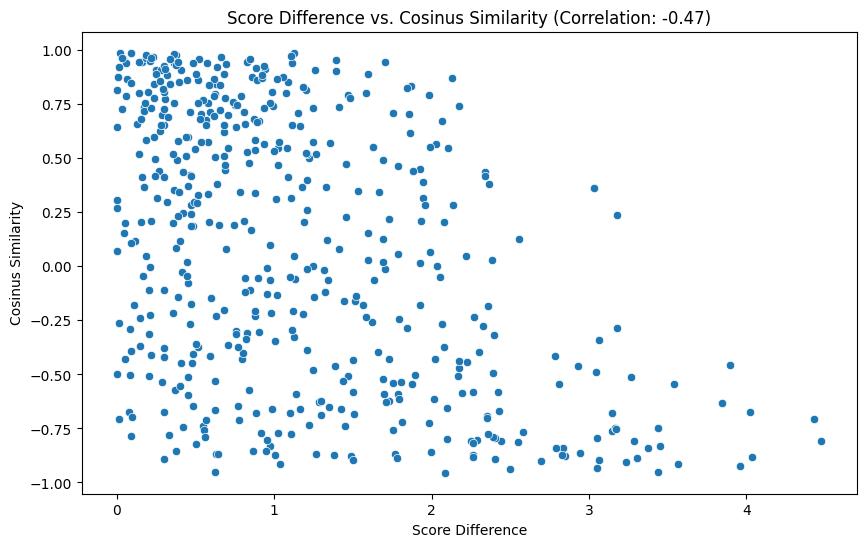

In [148]:
# Visualisation des rapport entre scores_diff et cos_sim
import matplotlib.pyplot as plt
import seaborn as sns

correlation = results_df['content_diff'].corr(results_df['cosine_similarity'])


plt.figure(figsize=(10, 6))
sns.scatterplot(x='content_diff', y='cosine_similarity', data=results_df)

plt.title(f'Score Difference vs. Cosinus Similarity (Correlation: {correlation:.2f})')
plt.xlabel('Score Difference')
plt.ylabel('Cosinus Similarity')

plt.show()


In [ ]:
# Suppression de ces deux enregistrements du DataFrame original
merged_df_featured = merged_df_featured.drop(r_star.index)
merged_df_featured = merged_df_featured.drop(r_random.index)

In [126]:
merged_df.shape

(7111, 17)

## 6️⃣ Combiner les deux réponses

In [131]:
# Extraire les textes de R et R*, les convertir en format JSON

# Extraction
good_answer_text = r_star['text'].iloc[0]
random_answer_text = r_random['text'].iloc[0]

# Conversion des textes en format JSON
combined_Rs = f'''{{
    "A": "{good_answer_text}",
    "B": "{random_answer_text}"
}}'''


In [132]:
combined_Rs

'{\n    "A": "The third wave developed over such a short period of time because the students all very quickly began to follow each other,  and did what jones had thought that they would do. The experiment was ended quickly because on the fourth day it began to quickly began to get out of hand, so jones lied and told them to attend a rally because this was a national wide rally. The rally is when jones revealed that they had been apart of an experiment to show how people willingly create leaders over others, that went to show how this can lead to people doing horrible things.  ",\n    "B": "When Ron Jones found it difficult to teach his students how people throughout history followed the crowd even when terrible things were happening, he decided to do an experiment. He created a sort of authoritarian class, even creating a salute similar to the nazis. The students got out of control incredibly quickly,  believing fully in the class and gaining an air of superiority over other students. 

In [142]:
api_key = getpass('OpenAI API key: ')

OpenAI API key: ········


In [143]:
os.environ["OPENAI_API_KEY"] = api_key

client = OpenAI()

In [160]:

# utiliser json pour former le prompt
texts = combined_Rs

completion = client.chat.completions.create(
  model="gpt-3.5-turbo-0301",
  messages=[
    {"role": "system", "content": 
     "Given 2 texts: A and B in a json format . You need to intergrate the key points of A into B without changing too much B's content, in order to return a new text."},
    {"role": "system", "content": 
     "The length of the new text created should be less than the sum of the lengths of two texts. Your output should be in a correct json format, with the key 'combined_text' and the value as the new text."},
    {"role": "system", "content": 
     "You should focus on the contenu"},
    {"role": "user", 
     "content": texts}
  ],
    temperature=0.3
    )
# print(completion.choices[0].message)
# print(dict(completion).get('usage'))

retour = completion.model_dump_json(indent=2)
retour_json = json.loads(data)
retour_texte = json.loads(json_data['choices'][0]['message']['content'])["combined_text"]

In [161]:
print(retour_texte)

When Ron Jones found it difficult to teach his students how people throughout history followed the crowd even when terrible things were happening, he decided to do an experiment. He created a sort of authoritarian class, even creating a salute similar to the nazis. The third wave developed over such a short period of time because the students all very quickly began to follow each other, and did what Jones had thought that they would do. The experiment was ended quickly because on the fourth day it began to quickly began to get out of hand, so Jones lied and told them to attend a rally because this was a national wide rally. The rally is when Jones revealed that they had been apart of an experiment to show how people willingly create leaders over others, that went to show how this can lead to people doing horrible things. In only four days the experiment had amassed 200 students and Jones felt it was slipping out of control. The next day, Jones stopped the experiment, telling the studen

In [162]:
print(len(retour_texte))
print(len(texts))


1066
1233


In [168]:
# créer un enregistrement

stu_id= '000000ffffff'
prompt_id = 'def789'
text_test = retour_texte

data_4_test = {
    'student_id': [stu_id],
    'prompt_id': [prompt_id],
    'text': [text_test]
}

test_data = pd.DataFrame(data_4_test)
# Jusqu'à ici, on a combiné les deux réponses.

test_data

,student_id,prompt_id,text
0,000000ffffff,def789,When Ron Jones found it difficult to teach his...


---

## 7️⃣ Modélisation et prédiction

In [ ]:

print(f'prompts_train shape: {prompts_train_df.shape}')
print(f'summaries_train shape: {merged_df.shape}')
print('-'*90)
print(f'prompts_train missing values: {prompts_train_df.isnull().sum().sum()}')
print(f'summaries_train missing values: {merged_df.isnull().sum().sum()}')
print('-'*90)
merged_df.head()

In [174]:
import pickle


def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    
    tokens = [token.lower() for token in tokens]
    
    tokens = [token for token in tokens if token.isalnum()]
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


In [175]:
# importer les données
train_text = merged_df.text
test_text = test_data.text
train_text

0       The third wave was an experimentto see how peo...
1       They would rub it up with soda to make the sme...
2       In Egypt, there were many occupations and soci...
3       The highest class was Pharaohs these people we...
4       The Third Wave developed  rapidly because the ...
                              ...                        
7160    They used all sorts of chemical concoctions to...
7161    The lowest classes are slaves and farmers slav...
7162               they sorta made people start workin...
7163    An ideal tragety has three elements that make ...
7164    The meat would smell sour but the would "rub i...
Name: text, Length: 7111, dtype: object

In [176]:
# pretraitement
pretraite_train_text = [preprocess_text(reponse) for reponse in train_text]
pretraite_text_text = [preprocess_text(reponse) for reponse in test_text]

In [196]:
train_tfidf_features = extract_features_tfidf(pretraite_train_text)

with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_tfidf_vectorizer = pickle.load(f)

test_tfidf_features = loaded_tfidf_vectorizer.transform(pretraite_text_text)

In [197]:
train_tfidf_features.shape

(7111, 11914)

In [198]:
test_tfidf_features.shape


(1, 11914)

In [211]:
target_labels = merged_df[['content']]
X_train, X_test, y_train, y_test = train_test_split(train_tfidf_features, target_labels, test_size=0.1, random_state=42)

# X_train = train_tfidf_features
# y_train = target_labels

In [212]:
# entraînement
regressor = XGBRegressor()
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

In [213]:
mse = mean_squared_error(y_test, predictions)
print(f"mse: {mse}")

mse: 0.3272186260452266


In [214]:
# 对单独的测试集使用训练好的模型进行预测
new_predictions = regressor.predict(test_tfidf_features)
print(f"Predictions on new data: {new_predictions}")

Predictions on new data: [2.1543388]


---